In [1]:
import numpy as np
np.random.seed(554)
from gauss import Gaus_HMM, gmm
from scipy.stats import multivariate_normal
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import pandas as pd
from matplotlib import rc
from moviepy.editor import VideoFileClip
import os
rc('animation', html='html5')
%matplotlib inline


Bad key "text.kerning_factor" on line 4 in
C:\Users\Ian\Anaconda3\envs\gaus\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.3/matplotlibrc.template
or from the matplotlib source distribution


In [2]:
def parse_data():
    num = float
    dtype = np.float32
    data = []
    with open('points.dat', 'r') as f:
        for line in f:
            data.append([num(t) for t in line.split()])
    dev_cutoff = int(.9*len(data))
    train_xs = np.asarray(data[:dev_cutoff],dtype=dtype)
    dev_xs = np.asarray(data[dev_cutoff:],dtype=dtype)
    return train_xs, dev_xs
train_xs, dev_xs = parse_data()

In [3]:
df = pd.read_csv('heart.csv')
df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


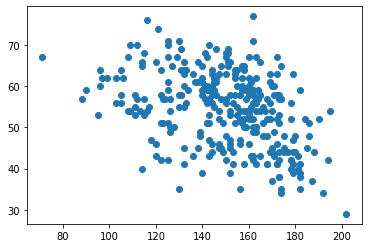

In [4]:
plt.scatter(df['thalach'], df['age'])

In [5]:
x = df[['thalach', 'age']].to_numpy()

In [6]:
g = Gaus_HMM(2,x)

In [7]:
x1 = np.linspace(80,200,50)
y1 = np.linspace(30,90, 50)
X, Y = np.meshgrid(x1,y1)
pos = np.empty(X.shape + (2,))
pos[:, :, 0] = X
pos[:, :, 1] = Y

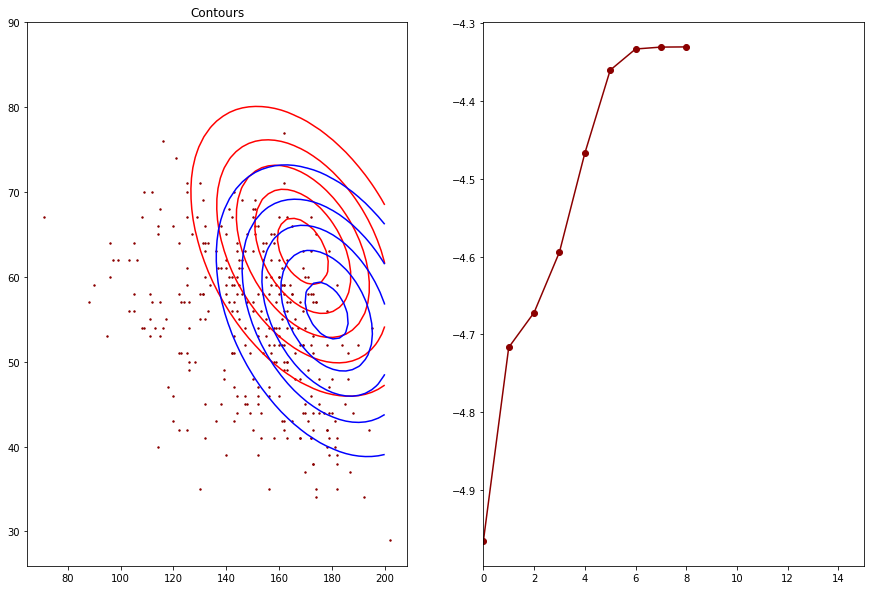

In [21]:
fig, ax = plt.subplots(1,2,figsize=(15,10))
l = [-4.966169497150268, -4.716922408759304, -4.672083224035471, -4.594247492390384, -4.467121644069037, -4.360209888057164, -4.3329913999091385, -4.330533015578627, -4.330296559547925]
ax[0].scatter(x[:,0], x[:,1], s = 2, c='darkred')
col = ['red', 'blue', 'green', 'purple', 'yellow']
for i in range(len(g.mus)):
    d1 = multivariate_normal(mean = g.mus[i], cov=g.sigmas[i])
    ax[0].contour(X, Y, d1.pdf(pos), levels = 5, colors=col[i])
ax[0].set_title('Contours')
ax[1].plot( np.arange(0,len(l)), l, marker='o', c='darkred')
ax[1].set_xlim(0,15)
plt.show()

In [9]:
g.forward(x)[1]

-9.116739561775143

#### Making the Gaussian MM into a gif

In [24]:
def gif_maker(clust_num, data, file_name, frames=10,t='seq'):
    if t == 'seq':
        g = Gaus_HMM(clust_num,data)
    else:
        g = gmm(clust_num, data)
    x1 = np.linspace(min(data[:,0]),max(data[:,0]),75)
    y1 = np.linspace(min(data[:,1]),max(data[:,1]), 75)
    X, Y = np.meshgrid(x1,y1)
    pos = np.empty(X.shape + (2,))
    pos[:, :, 0] = X
    pos[:, :, 1] = Y
    levels = 3
    
    log_like = []
    def calc_log_like(model, log_like):
        if t == 'seq':
            log_like.append(model.forward(data)[1])
        else:
            log_like.append(model.log_like(data))
    def init_func():
        # For some reason the animation function with run i=0 twice if there is no initial function
        pass
    
    fig, ax = plt.subplots(1,2,figsize=(15,10))
    fig.set_tight_layout(True)
    def update(i):
        ax[0].clear()
        ax[1].clear()
        if i == 0:
            calc_log_like(g, log_like)
            cs = ax[0].scatter(data[:,0], data[:,1], s = 20, c=np.arange(0, len(data[:,0])), cmap='viridis')
            cbar = fig.colorbar(cs)
            cbar.ax.set_yticklabels(['t={}'.format(i) for i in np.arange(0,120,20)])
            for j in range(len(g.mus)):
                d1 = multivariate_normal(mean = g.mus[j], cov=g.sigmas[j])
                ax[0].contour(X, Y, d1.pdf(pos), levels = levels, colors=col[j])
            ax[0].set_title('Iteration {}'.format(i))
            ax[1].plot(np.arange(0,len(log_like)), log_like)
            ax[1].set_xlim(0, frames)

        else:
            g.train(data,1)
            calc_log_like(g, log_like)
            cs = ax[0].scatter(data[:,0], data[:,1], s = 20, c=np.arange(0, len(data[:,0])), cmap='viridis')
            for j in range(len(g.mus)):
                d1 = multivariate_normal(mean = g.mus[j], cov=g.sigmas[j])
                ax[0].contour(X, Y, d1.pdf(pos), levels = levels, colors=col[j])
            ax[0].set_title('Iteration {}'.format(i))
            ax[1].plot(np.arange(0,len(log_like)), log_like, c='darkred', marker='o')
            ax[1].set_xlim(0, frames)
        return ax
    anim = FuncAnimation(fig, update, frames=np.arange(0, frames), interval=300, init_func=init_func)
    anim.save(file_name + '.gif', dpi=80, writer='imagemagick')

MovieWriter imagemagick unavailable; trying to use <class 'matplotlib.animation.PillowWriter'> instead.


[]
[-6.276001791821811]
[-6.276001791821811, -4.689923015160989]
[-6.276001791821811, -4.689923015160989, -4.660695203863065]
[-6.276001791821811, -4.689923015160989, -4.660695203863065, -4.629104990119518]
[-6.276001791821811, -4.689923015160989, -4.660695203863065, -4.629104990119518, -4.601002097232839]
[-6.276001791821811, -4.689923015160989, -4.660695203863065, -4.629104990119518, -4.601002097232839, -4.583545916730888]
[-6.276001791821811, -4.689923015160989, -4.660695203863065, -4.629104990119518, -4.601002097232839, -4.583545916730888, -4.568681672630722]
[-6.276001791821811, -4.689923015160989, -4.660695203863065, -4.629104990119518, -4.601002097232839, -4.583545916730888, -4.568681672630722, -4.5483978483427645]
[-6.276001791821811, -4.689923015160989, -4.660695203863065, -4.629104990119518, -4.601002097232839, -4.583545916730888, -4.568681672630722, -4.5483978483427645, -4.51254707645417]


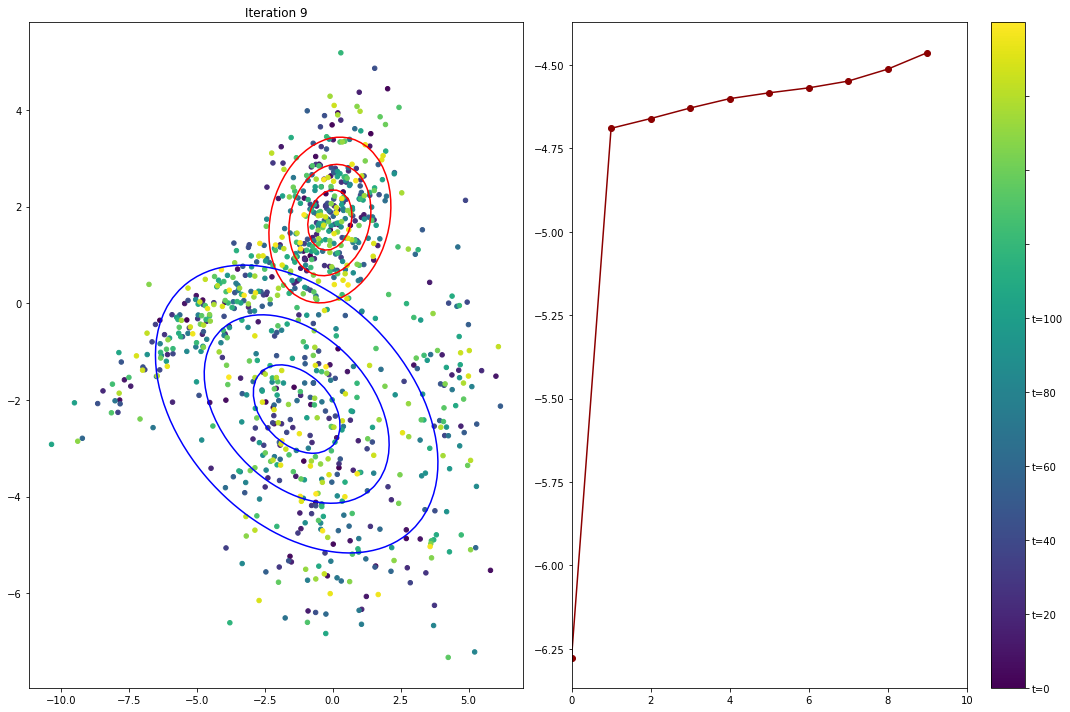

In [25]:
gif_maker(2, train_xs, 'cont');

#### Messing around with time order in the data

In [33]:
initial_mu = np.random.uniform(-20,20, size=2)
initial_sig = np.random.uniform(-40,40, size=(2,2))
num_points = 300
l = [initial_mu]
for i in range(num_points):
    l.append(np.random.multivariate_normal(l[i], initial_sig))
    
time_dat = np.array(l)

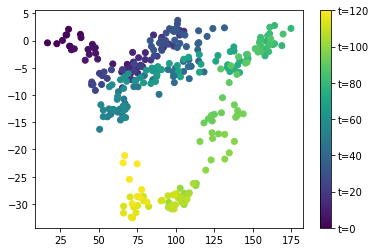

In [34]:
fig, ax = plt.subplots()
cs = ax.scatter(time_dat[:,0], time_dat[:,1], c = np.arange(0, len(time_dat[:,0])), cmap='viridis')
cbar = fig.colorbar(cs)
cbar.ax.set_yticklabels(['t={}'.format(i) for i in np.arange(0,140,20)])
plt.show()

### Gifs for gaussian models

MovieWriter imagemagick unavailable; trying to use <class 'matplotlib.animation.PillowWriter'> instead.


[]
[-8.888027638522267]
[-8.888027638522267, -8.348532561145522]
[-8.888027638522267, -8.348532561145522, -7.87412811806444]
[-8.888027638522267, -8.348532561145522, -7.87412811806444, -7.38736256212397]
[-8.888027638522267, -8.348532561145522, -7.87412811806444, -7.38736256212397, -7.257170354924354]
[-8.888027638522267, -8.348532561145522, -7.87412811806444, -7.38736256212397, -7.257170354924354, -7.25017741178881]
[-8.888027638522267, -8.348532561145522, -7.87412811806444, -7.38736256212397, -7.257170354924354, -7.25017741178881, -7.248718737738809]
[-8.888027638522267, -8.348532561145522, -7.87412811806444, -7.38736256212397, -7.257170354924354, -7.25017741178881, -7.248718737738809, -7.2477791814283865]
[-8.888027638522267, -8.348532561145522, -7.87412811806444, -7.38736256212397, -7.257170354924354, -7.25017741178881, -7.248718737738809, -7.2477791814283865, -7.247115149494968]
[-8.888027638522267, -8.348532561145522, -7.87412811806444, -7.38736256212397, -7.257170354924354, -7.2

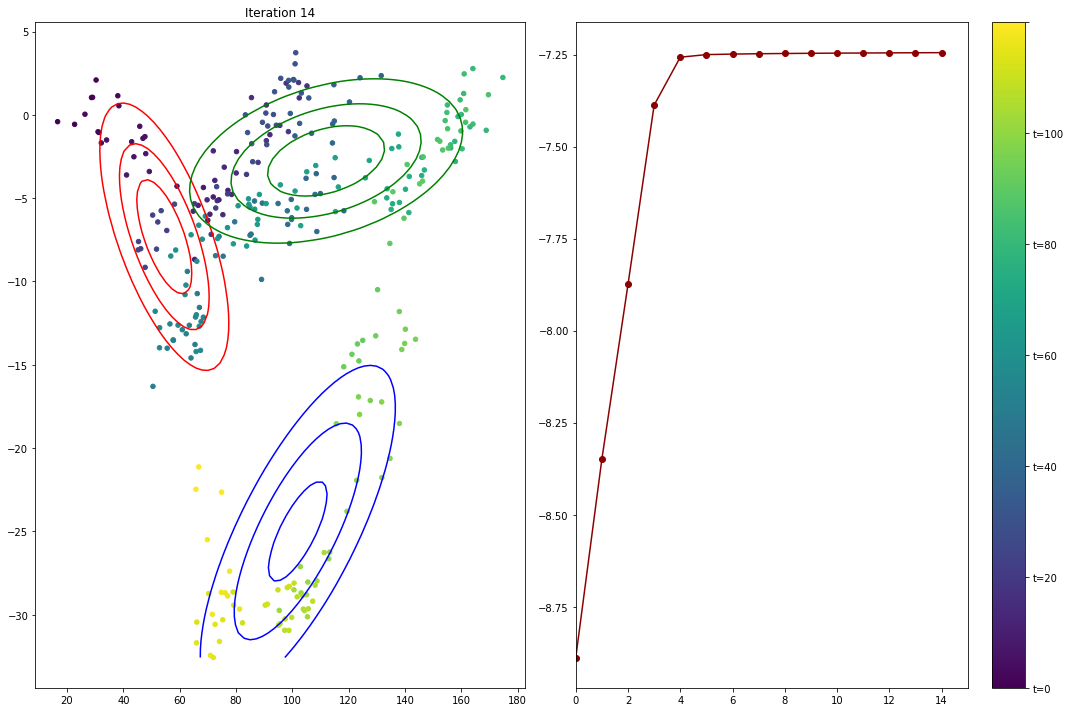

In [47]:
gif_maker(3,time_dat, 'g1', 15);

MovieWriter imagemagick unavailable; trying to use <class 'matplotlib.animation.PillowWriter'> instead.


[]
[-8.884059915995582]
[-8.884059915995582, -8.521969894913447]
[-8.884059915995582, -8.521969894913447, -8.340689606437351]
[-8.884059915995582, -8.521969894913447, -8.340689606437351, -8.205510284723706]
[-8.884059915995582, -8.521969894913447, -8.340689606437351, -8.205510284723706, -8.182194733489268]
[-8.884059915995582, -8.521969894913447, -8.340689606437351, -8.205510284723706, -8.182194733489268, -8.176878399741028]
[-8.884059915995582, -8.521969894913447, -8.340689606437351, -8.205510284723706, -8.182194733489268, -8.176878399741028, -8.173642961435146]
[-8.884059915995582, -8.521969894913447, -8.340689606437351, -8.205510284723706, -8.182194733489268, -8.176878399741028, -8.173642961435146, -8.171519437525435]
[-8.884059915995582, -8.521969894913447, -8.340689606437351, -8.205510284723706, -8.182194733489268, -8.176878399741028, -8.173642961435146, -8.171519437525435, -8.169488281338525]
[-8.884059915995582, -8.521969894913447, -8.340689606437351, -8.205510284723706, -8.1821

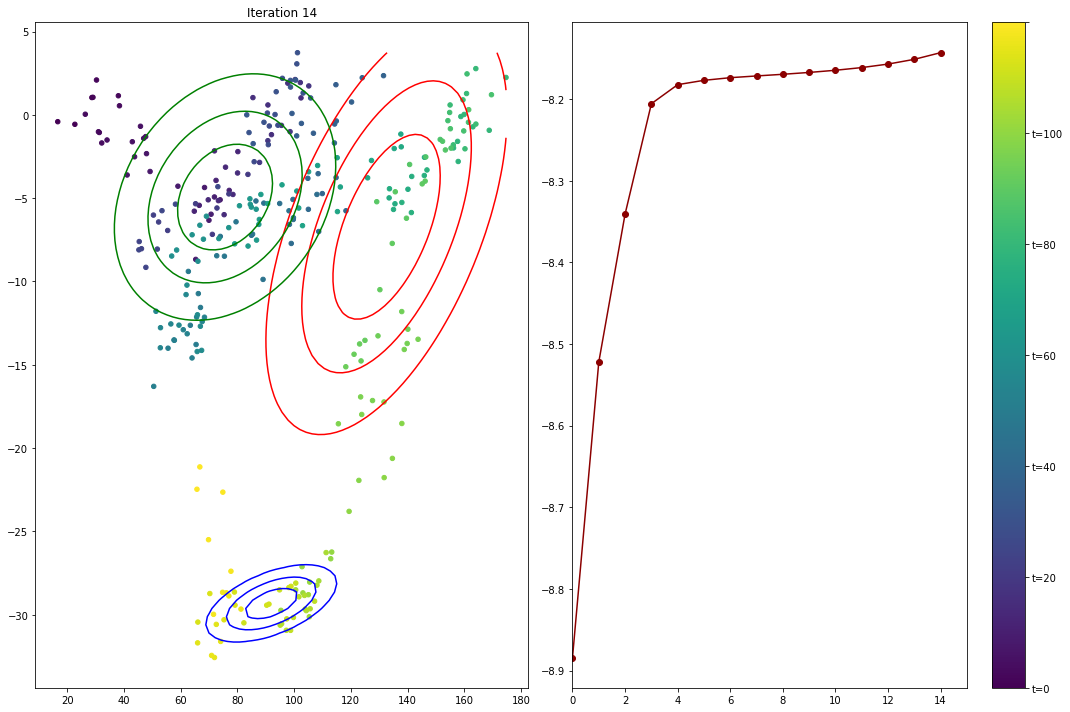

In [48]:
gif_maker(3, time_dat, 'g2', 15,t='nonseq')

### Comparing the two models for many different restarts

In [56]:
def comp_ggm(data, n_samples, training_iterations, clust_num):
    nonseq = []
    seq = []
    for n in range(n_samples):
        g = gmm(clust_num, data)
        g.train(data, training_iterations)
        nonseq.append(g.log_like(data))
        
        g = Ga
    return (nonseq, seq)

In [57]:
comp_ggm(time_dat, 2, 2, 2)

([-8.473863251624012, -8.55385577753175], [])

### KMeans

In [41]:
class KMeans:
    def __init__(self, num_clust, data):
        self.num_clust = num_clust
        self.centers = data[np.random.randint(0,len(data), self.num_clust)]
    
    def class_point(self, point):
        d = []
        for center in self.centers:
            dist = np.sum([(i-j)**2 for i,j in zip(point, center)])
            d.append(np.sqrt(dist))
        return np.argmin(d)
    
    def train(self, iterations, data):
        for i in range(iterations):
            labels = []
            for point in data:
                labels.append(self.class_point(point))
            labels = np.array(labels)
            for clust in range(self.num_clust):
                self.centers[clust, :] = data[labels == clust, :].mean(axis=0)
                
    def label_points(self, data):
        labels = []
        for point in data:
            labels.append(self.class_point(point))
        return np.array(labels)

In [42]:
kmeans = KMeans(3, time_dat)

In [43]:
kmeans.train(1,time_dat)
kmeans.centers

array([[157.0705256 ,  -0.92325426],
       [137.58657015,  -7.34908221],
       [ 83.35309253, -10.56523742]])

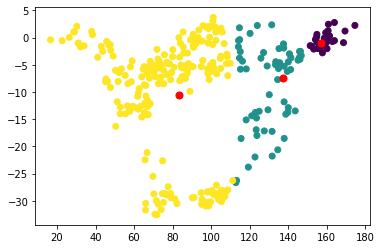

In [44]:
plt.scatter(time_dat[:,0], time_dat[:,1], c=((kmeans.label_points(time_dat))+2))
plt.scatter(kmeans.centers[:, 0], kmeans.centers[:, 1], s=50, c='red')

In [45]:
def kmeans_anim(clust_num, data, file_name, frames=6):
    g = KMeans(clust_num, data)
    
    def init_func():
        # For some reason the animation function with run i=0 twice if there is no initial function
        pass
    
    fig, ax = plt.subplots(figsize=(10,10))
    fig.set_tight_layout(True)
    def update(i):
        ax.clear()
        ax.set_title('Iteration {}'.format(i))
        if i == 0:
            cs = ax.scatter(data[:,0], data[:,1], s = 20, c=g.label_points(data))
            ax.scatter(g.centers[:,0], g.centers[:,1], s=50, c='red')

        else:
            g.train(1,data)
            cs = ax.scatter(data[:,0], data[:,1], s = 20, c=g.label_points(data))
            ax.scatter(g.centers[:,0], g.centers[:,1], s=50, c='red')
        return ax
    anim = FuncAnimation(fig, update, frames=np.arange(0, frames), interval=300, init_func=init_func)
    anim.save(file_name + '.gif', dpi=80, writer='imagemagick')

MovieWriter imagemagick unavailable; trying to use <class 'matplotlib.animation.PillowWriter'> instead.


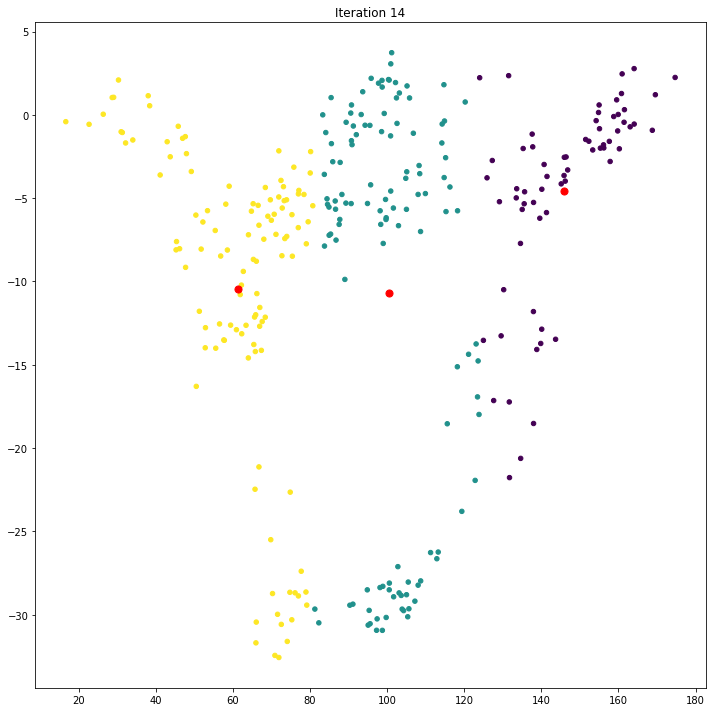

In [46]:
kmeans_anim(3,time_dat, 'kmeans', 15)